In [12]:
#!pip uninstall huetracer -y
#!pip install huetracer
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import pandas as pd
import huetracer
import scvi
import gc
import math
import bin2cell as b2c
import torch
from itertools import cycle
import warnings

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

scvi.settings.seed = 0
SEED = 42

np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else"mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
device_str = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
warnings.filterwarnings("ignore", message="The value argument must be within the support")

Seed set to 0


Using device: mps


In [6]:
### parameters to be input
SAMPLE_NAME = 'Colon'
lib_id = 'Visium_HD_Human_Colon_Cancer' # list(sp_adata.uns['spatial'].keys())[0]

path = os.path.expanduser("~")+"/Desktop/space/colon"
save_path_for_today = "outputs/250610_" + SAMPLE_NAME
source_image_path = "../VisiumHD/image/microscope_image/Visium_HD_Human_Colon_Cancer_tissue_image.btf"
output_tiff_path = "../VisiumHD/image/microscope_image/Visium_HD_Human_Colon_Cancer_tissue_image_full_res.tiff"
expression_path = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_002um"
### optional 8 um binned dataset
expression_path_8um = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_008um"
###

# area to be analyzed
mask_small_x1, mask_small_x2, mask_small_y1, mask_small_y2 = 1250, 1550, 50, 350
mask_large_x1, mask_large_x2, mask_large_y1, mask_large_y2 = 250, 1750, 50, 1550

# List of target gene names
target_genes = [
    'TNFSF11', 'LIF', 'TNFRSF11A', 'LIFR',
    'CTSK', 'CTSB', 'LMNB1', 'MEGF10',
    'MMP9', 'MMP13', 'SPP1', 'GRN',
    'NOTCH3', 'SDC2', 'TIMP1', 'SPARC',
    'ACP5'
    # Add more genes here if needed
]

# Manual single cell transcriptome cluster annotation
annotation_dict = {
    'C0':  'Plasma_B',
    'C1':  'Plasma_B',
    'C2':  'Epithelial_Tumor',
    'C3':  'Plasma_B',
    'C4':  'CAF_Fibroblast',  # COL1A1, COL1A2, COL3A1 - 細胞外マトリックス産生
    'C5':  'Macrophage',  # CTSB, PSAP, CTSZ, C1QC - リソソーム酵素とマクロファージマーカー
    'C6':  'CAF_Myofibroblast',  # DCN, TNXB, MGP - 細胞外マトリックス調節
    'C7':  'Smooth_Muscle_Cell',  # MYL9, MYH11, TAGLN, MYLK - 平滑筋特異的マーカー
    'C8':  'Epithelial_Secretory',  # PIGR, LGALS4, PHGR1 - 分泌機能を持つ上皮細胞
    'C9':  'Plasma_B',
    'C10': 'Epithelial_Tumor',  # GPX2, S100P, KRT8 - 腫瘍上皮細胞
    'C11': 'CAF_ECM_Rich',  # COL3A1, COL1A1, COL1A2, SPARC - ECM豊富なCAF
    'C12': 'Pericyte_Vascular',  # IGFBP7, EPAS1, COL4A1, COL4A2 - 血管周皮細胞
    'C13': 'Epithelial_Goblet',  # FCGBP, TSPAN1, PIGR - 杯細胞
    'C14': 'Myofibroblast',  # COL6A1, PDLIM7, SMTN - 筋線維芽細胞
    'C15': 'T_Cell',  # TRAC, TRBC2, CD2, CD3E, CD3D - T細胞受容体複合体
    'C16': 'Plasma_B',
    'C17': 'Endothelial',  # PECAM1, CDH5, EGFL7, ECSCR - 内皮細胞特異的
    'C18': 'Myeloid_Monocyte',  # LCP1, SPI1, LYZ, CD74 - 単球系骨髄細胞
    'C19': 'Proliferating_Cell',  # HIST1H1C, HIST1H1B, HIST1H1D, MKI67 - 増殖細胞
    'C20': 'CAF_Inflammatory',  # CXCL14, A2M, ADAMDEC1 - 炎症性CAF
    'C21': 'Plasma_B',
    'C22': 'Macrophage_M2',  # STAB1, CD163, C1QA, CSF1R, MRC1 - M2マクロファージ
    'C23': 'Plasma_B',
    'C24': 'Epithelial_Tumor_CEACAM',  # CEACAM6, CEACAM5, MUC12 - CEACAM高発現腫瘍上皮
    'C25': 'Plasma_B',
    'C26': 'Myeloid_Antigen_Presenting',  # IFI30, LYZ, SPI1, FCER1G - 抗原提示細胞
    'C27': 'Plasma_B',
    'C28': 'Epithelial_Mesenchymal_Transition',  # L1CAM, NCAM1, DKK3, CRYAB - EMT関連
    'C29': 'Plasma_B',
    'C30': 'Plasma_B',
    'C31': 'B_Cell_Follicular',  # CXCL13, CD37, CR2, CXCR4, BANK1 - 濾胞性B細胞
}

# setting for filenames
label_image_filename = "he_labels_image.pdf"
h5ad_filename = SAMPLE_NAME + "_b2c.h5ad"
h5ad_full_filename = SAMPLE_NAME + "_2um.h5ad"
h5ad_predicted_full_filename = SAMPLE_NAME + "_nucleus_predicted.h5ad"
h5ad_sc_filtered_full_filename = SAMPLE_NAME + "_single_cell_filtered.h5ad"
h5ad_sc_microenvironment_full_filename = SAMPLE_NAME + "_single_cell_microenvironment.h5ad"
save_spatial_plot_path = os.path.join(save_path_for_today, "cropped_spatial_plot.svg")
save_svg_path = os.path.join(save_path_for_today, "spatial_salvage_labels.svg")
h5ad_save_path = os.path.join(save_path_for_today, h5ad_filename)
h5ad_full_save_path = os.path.join(save_path_for_today, h5ad_full_filename)
h5ad_predicted_full_save_path = os.path.join(save_path_for_today, h5ad_predicted_full_filename)
h5ad_sc_filtered_full_save_path = os.path.join(save_path_for_today, h5ad_sc_filtered_full_filename)
h5ad_microenvironment_full_save_path = os.path.join(save_path_for_today, h5ad_sc_microenvironment_full_filename)

os.chdir(path)
os.makedirs(save_path_for_today, exist_ok=True)


# Label transfer from single cell transcriptome annotation to spacial dataset

In [ ]:
# Spatial data load and curation
sp_adata_raw = sc.read_h5ad(h5ad_save_path)
filtered_sc_adata = sc.read_h5ad(h5ad_sc_filtered_full_save_path)
cell_mask = ((sp_adata_raw.obs['array_row'] >= mask_large_x1) & 
             (sp_adata_raw.obs['array_row'] <= mask_large_x2) & 
             (sp_adata_raw.obs['array_col'] >= mask_large_y1) & 
             (sp_adata_raw.obs['array_col'] <= mask_large_y2)
            )
sp_adata = sp_adata_raw[cell_mask]
sp_adata.var_names_make_unique()
sp_adata = sp_adata[sp_adata.obs['bin_count']>5] # min 6 bins
#need integers for seuratv3 hvgs
sp_adata.X = np.round(sp_adata.X).copy()
sp_adata.raw = sp_adata.copy()
sp_adata.var['MT'] = sp_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sp_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
# sc.pl.highest_expr_genes(sp_adata, n_top=30)
# sc.pl.violin(sp_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(sp_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
# sc.pl.scatter(sp_adata, x='total_counts', y='pct_counts_MT')
# fig = plt.figure()
# sns.displot(sp_adata.obs['pct_counts_MT'][sp_adata.obs['pct_counts_MT'] < 10], kde=False)
# plt.show()

print('Total number of cells: {:d}'.format(sp_adata.n_obs))

# Filtering
# sc.pp.filter_cells(sp_adata, min_genes=40)
# sc.pp.filter_genes(sp_adata, min_cells=100)
# print('Number of cells after low-quality cell filter: {:d}'.format(sp_adata.n_obs))

sc.pp.filter_cells(sp_adata, min_counts = 200)
#sc.pp.filter_cells(sp_adata, max_counts = 2000)
print('Number of cells after count filter: {:d}'.format(sp_adata.n_obs))

sp_adata = sp_adata[sp_adata.obs['pct_counts_MT'] < 10]
print('Number of cells after MT filter: {:d}'.format(sp_adata.n_obs))

# sc.pl.highest_expr_genes(sp_adata, n_top=30)
# sc.pl.violin(sp_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(sp_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
# sc.pl.scatter(sp_adata, x='total_counts', y='pct_counts_MT')
# fig = plt.figure()
# sns.displot(sp_adata.obs['pct_counts_MT'][sp_adata.obs['pct_counts_MT'] < 10], kde=False)
# plt.show()
# save raw count data
sp_adata.layers["counts"] = sp_adata.X.copy()
sp_adata.raw = sp_adata

# reset with raw count data
sp_adata_sponly = sp_adata.copy()
sp_adata_sponly.X = sp_adata_sponly.raw.X.copy()
sp_adata_sponly.var = sp_adata_sponly.raw.var.copy()
sp_adata_sponly.layers["counts"] = sp_adata_sponly.X.copy()
sc.pp.normalize_total(sp_adata_sponly)
sc.pp.log1p(sp_adata_sponly)
sc.pp.highly_variable_genes(sp_adata_sponly,
                            flavor = 'seurat_v3',
                            n_top_genes=2000,
                            layer = "counts",
                            subset = False)
sc.tl.pca(sp_adata_sponly, svd_solver='arpack',mask_var='highly_variable', n_comps=20)
sc.pp.neighbors(sp_adata_sponly, random_state=SEED)
sc.tl.umap(sp_adata_sponly, random_state=SEED)
sc.tl.leiden(sp_adata_sponly, resolution=1, key_added='leiden', random_state=SEED)
sc.pl.pca(sp_adata_sponly, color='total_counts', components=['1,2', '2,3', '1,3'])
sc.pl.pca_variance_ratio(sp_adata_sponly, log=True)
#sc.tl.rank_genes_groups(sp_adata_sponly, 'leiden', method='wilcoxon', use_raw=False)
#sc.pl.rank_genes_groups(sp_adata_sponly, n_genes=25, sharey=False)
#sp_adata_sponly.var.sort_values("variances_norm",ascending=False).head(10)
sc.pl.umap(sp_adata_sponly, color=['leiden', 'total_counts'],use_raw=False)
sc.pl.umap(sp_adata_sponly, color=['RUNX2', 'CTSK', 'LYZ'],use_raw=False)
sc.pl.umap(sp_adata_sponly, color=['CD163', 'COL12A1', 'COL1A1'],use_raw=False)
sc.pl.umap(sp_adata_sponly, color=['IL2RG', 'CDH5', 'TRAC'],use_raw=False)
sc.pl.spatial(sp_adata_sponly, color=["leiden"], title='Annotation for nuclei, sp data only',
    size=20,img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer",legend_fontsize=5,
    spot_size=1,
    frameon=False,save=False)
sp_adata.obs['leiden_nucleus'] = sp_adata_sponly.obs['leiden']
sp_adata.obsm['X_PCA_nucleus'] = sp_adata_sponly.obsm['X_pca']
sp_adata.obsm['X_umap_nucleus'] = sp_adata_sponly.obsm['X_umap']

In [ ]:
# Spatial data of 8um bin, option for comparing
sp_adata_bin = b2c.read_visium(expression_path_8um, source_image_path = source_image_path)
sp_adata_bin.var_names_make_unique()
cell_mask = ((sp_adata_bin.obs['array_row'] / sp_adata_bin.uns['spatial'][lib_id]['scalefactors']['microns_per_pixel'] >= mask_large_x1) & 
             (sp_adata_bin.obs['array_row'] / sp_adata_bin.uns['spatial'][lib_id]['scalefactors']['microns_per_pixel'] <= mask_large_x2) & 
             (sp_adata_bin.obs['array_col'] / sp_adata_bin.uns['spatial'][lib_id]['scalefactors']['microns_per_pixel'] >= mask_large_y1) & 
             (sp_adata_bin.obs['array_col'] / sp_adata_bin.uns['spatial'][lib_id]['scalefactors']['microns_per_pixel'] <= mask_large_y2)
            )
sp_adata_bin = sp_adata_bin[cell_mask]
sp_adata_bin.var_names_make_unique()
sp_adata_bin.raw = sp_adata_bin.copy()
sp_adata_bin.var['MT'] = sp_adata_bin.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sp_adata_bin, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
# sc.pl.highest_expr_genes(sp_adata_bin, n_top=30)
# sc.pl.violin(sp_adata_bin, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(sp_adata_bin, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
# sc.pl.scatter(sp_adata_bin, x='total_counts', y='pct_counts_MT')
# fig = plt.figure()
# sns.displot(sp_adata_bin.obs['pct_counts_MT'][sp_adata_bin.obs['pct_counts_MT'] < 10], kde=False)
# plt.show()

print('Total number of cells: {:d}'.format(sp_adata_bin.n_obs))
# Filtering
sc.pp.filter_cells(sp_adata_bin, min_genes=40)
sc.pp.filter_genes(sp_adata_bin, min_cells=100)
print('Number of cells after low-quality cell filter: {:d}'.format(sp_adata_bin.n_obs))

sc.pp.filter_cells(sp_adata_bin, min_counts = 100)
sc.pp.filter_cells(sp_adata_bin, max_counts = 1500)
print('Number of cells after count filter: {:d}'.format(sp_adata_bin.n_obs))

sp_adata_bin = sp_adata_bin[sp_adata_bin.obs['pct_counts_MT'] < 10]
print('Number of cells after MT filter: {:d}'.format(sp_adata_bin.n_obs))

# sc.pl.highest_expr_genes(sp_adata_bin, n_top=30)
# sc.pl.violin(sp_adata_bin, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(sp_adata_bin, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
# sc.pl.scatter(sp_adata_bin, x='total_counts', y='pct_counts_MT')
# fig = plt.figure()
# sns.displot(sp_adata_bin.obs['pct_counts_MT'][sp_adata_bin.obs['pct_counts_MT'] < 10], kde=False)
# plt.show()
# save raw count data
sp_adata_bin.layers["counts"] = sp_adata_bin.X.copy()
sp_adata_bin.raw = sp_adata_bin

# reset with raw count data
sp_adata_sponly = sp_adata_bin.copy()
sp_adata_sponly.X = sp_adata_bin.raw.X.copy()
sp_adata_sponly.var = sp_adata_bin.raw.var.copy()
sp_adata_sponly.layers["counts"] = sp_adata_sponly.X.copy()
sc.pp.normalize_total(sp_adata_sponly)
sc.pp.log1p(sp_adata_sponly)
sc.pp.highly_variable_genes(sp_adata_sponly,
                            flavor = 'seurat_v3',
                            n_top_genes=2000,
                            layer = "counts",
                            subset = False)
sc.tl.pca(sp_adata_sponly, svd_solver='arpack',mask_var='highly_variable', n_comps=20)
sc.pp.neighbors(sp_adata_sponly, random_state=SEED)
sc.tl.umap(sp_adata_sponly, random_state=SEED)
sc.tl.leiden(sp_adata_sponly, resolution=1, key_added='leiden', random_state=SEED)
sc.pl.pca(sp_adata_sponly, color='total_counts', components=['1,2', '2,3', '1,3'])
sc.pl.pca_variance_ratio(sp_adata_sponly, log=True)
#sc.tl.rank_genes_groups(sp_adata_sponly, 'leiden', method='wilcoxon', use_raw=False)
#sc.pl.rank_genes_groups(sp_adata_sponly, n_genes=25, sharey=False)
#sp_adata_sponly.var.sort_values("variances_norm",ascending=False).head(10)
sc.pl.umap(sp_adata_sponly, color=['leiden', 'total_counts'],use_raw=False)
sc.pl.umap(sp_adata_sponly, color=['RUNX2', 'CTSK', 'LYZ'],use_raw=False)
# sc.pl.umap(sp_adata_sponly, color=['CD163', 'COL12A1', 'COL1A1'],use_raw=False)
# sc.pl.umap(sp_adata_sponly, color=['IL2RG', 'CDH5', 'TRAC'],use_raw=False)
sc.pl.spatial(sp_adata_sponly, color='leiden',
              title='Annotation for 8um-bin', size=20, img_key='hires', legend_fontsize=5,
              spot_size=1, frameon=False, )

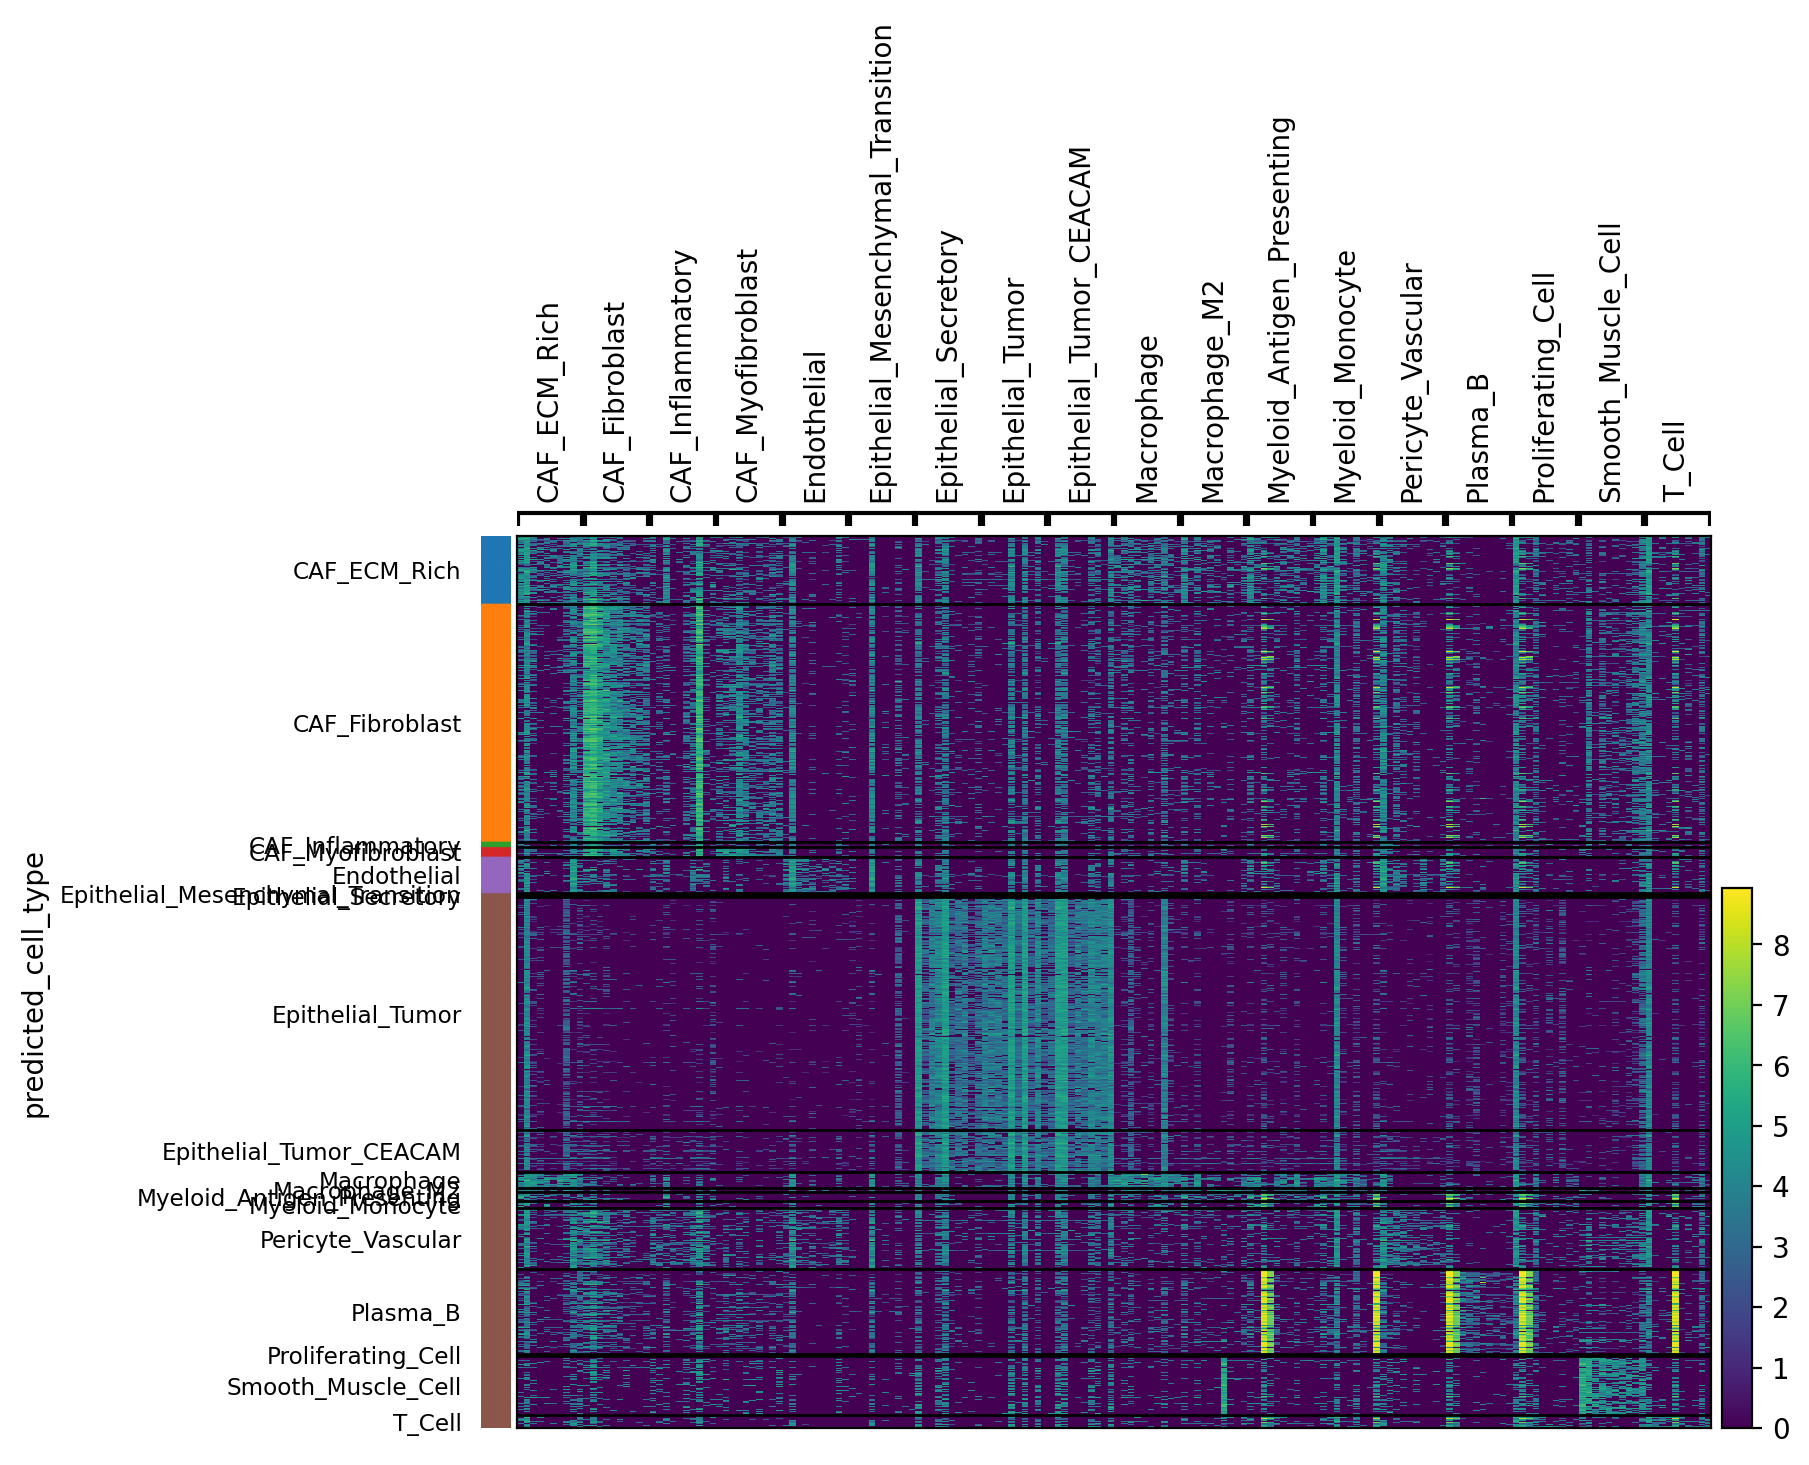

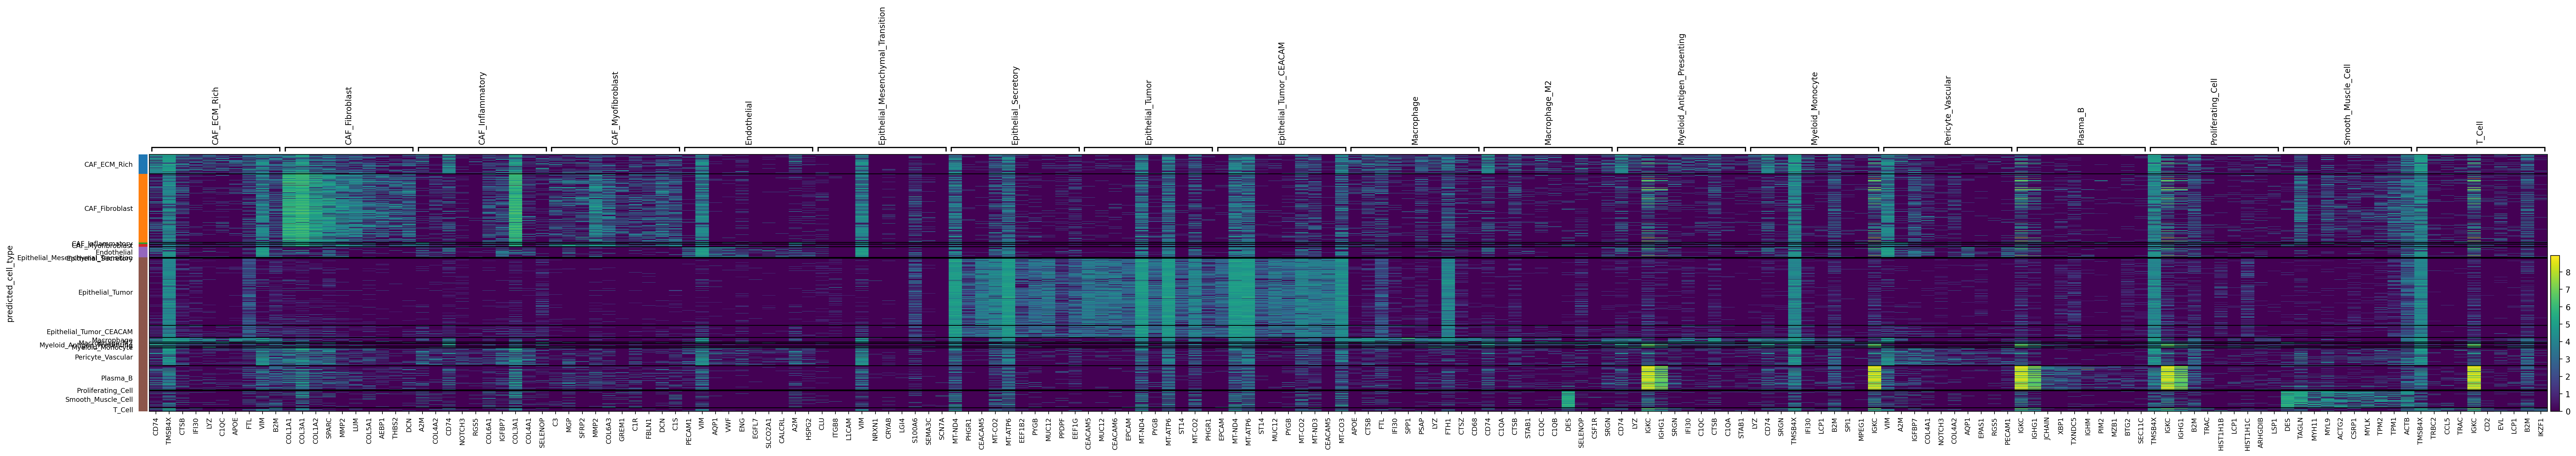

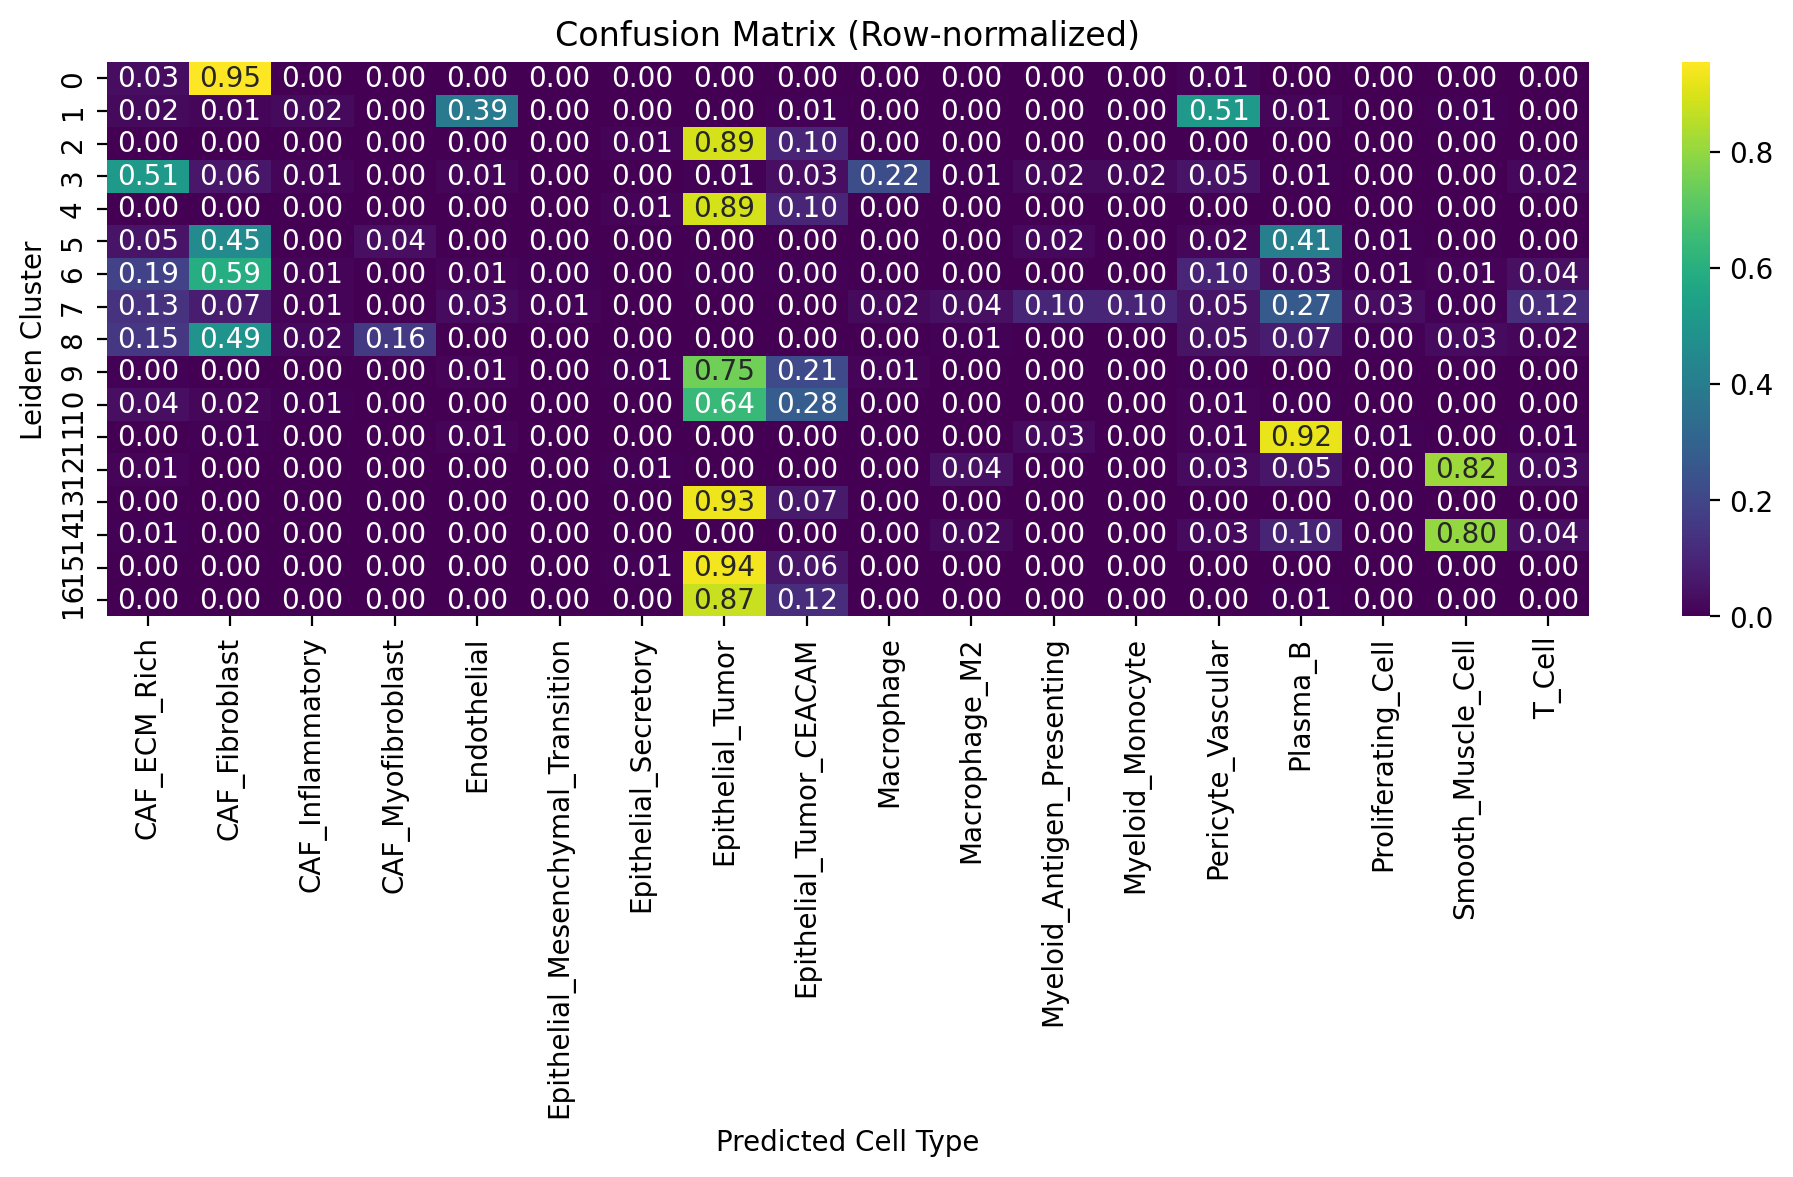

2604493105.py (110): Use `squidpy.pl.spatial_scatter` instead.


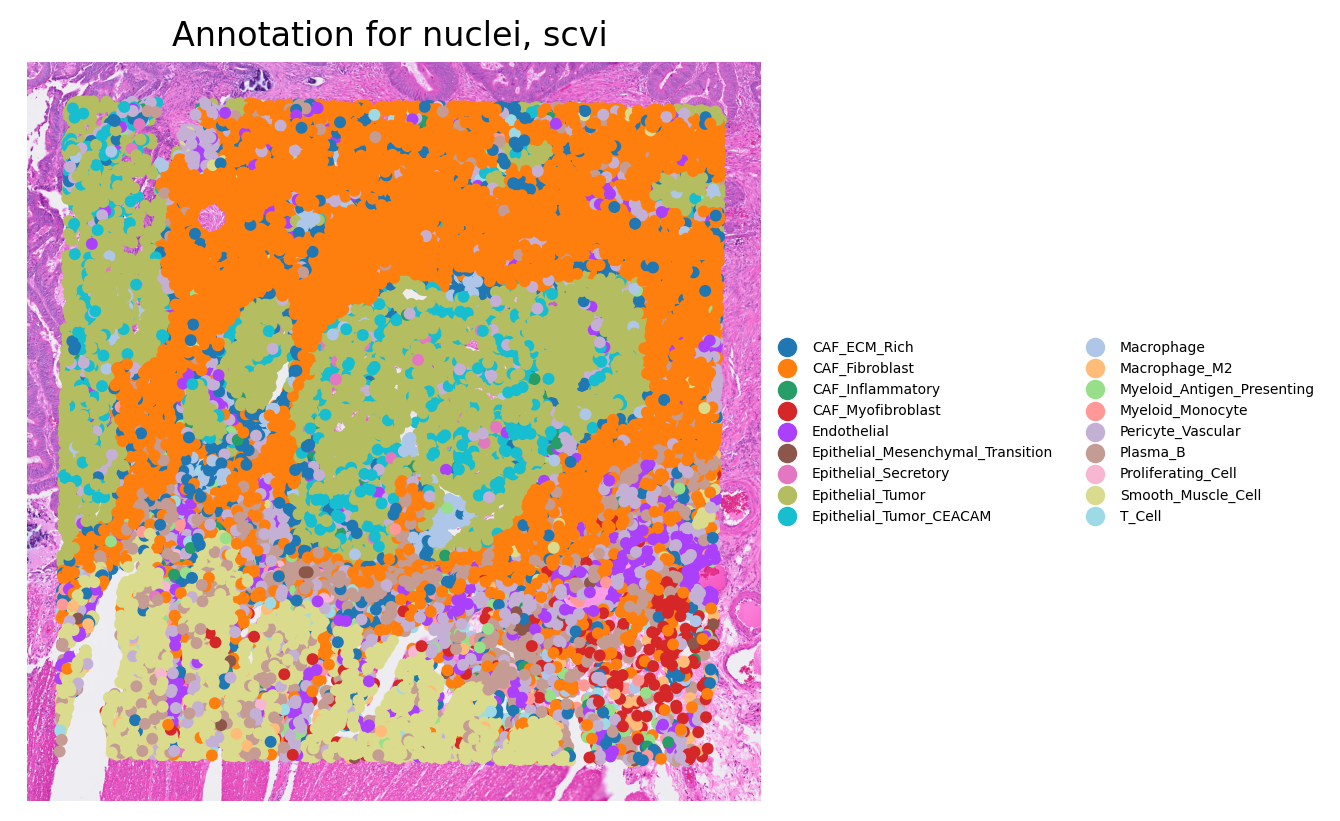

In [31]:
# # SCVI lavel transfer code, the best method
# # 両データを統合
# # Manual cell label transfer from single cell to spatial data, not used.
# adata_ref = filtered_sc_adata.copy()
# adata_ref.obs['batch'] = 'reference'
# adata_ref.X = adata_ref.raw.X.copy()
# adata_ref.var = adata_ref.raw.var.copy()
# adata_ref.raw = None
# adata_query = sp_adata.copy()
# adata_query.obs['batch'] = 'query'
# adata_query.X = adata_query.raw.X
# adata_query.var = adata_query.raw.var.copy()
# adata_query.raw = None

# adata_combined = filtered_sc_adata.concatenate(sp_adata, batch_key="dataset")

# print(f"Using device: {device}")
# # scANVI モデルの学習とラベル転送
# scvi.model.SCVI.setup_anndata(adata_combined, batch_key="dataset")
# model = scvi.model.SCVI(adata_combined)
# model.module.to(device)
# model.train(accelerator=device_str)

# cat_col = adata_combined.obs['cell_type_annotation']

# # カテゴリ型であれば Unknown を追加
# if isinstance(cat_col.dtype, pd.CategoricalDtype):
#     if "Unknown" not in cat_col.cat.categories:
#         cat_col = cat_col.cat.add_categories(["Unknown"])

# # 欠損値を Unknown に置き換える
# adata_combined.obs['cell_type_annotation'] = cat_col.fillna("Unknown")
# adata_combined.obs['cell_type_annotation'] = adata_combined.obs['cell_type_annotation'].fillna('Unknown')
# categories = adata_combined.obs['cell_type_annotation'].unique().tolist()
# if "Unknown" not in categories:
#     categories.append("Unknown")
# adata_combined.obs['cell_type_annotation'] = pd.Categorical(
#     adata_combined.obs['cell_type_annotation'],
#     categories=categories
# )

# scvi.model.SCANVI.setup_anndata(adata_combined, labels_key="cell_type_annotation", unlabeled_category="Unknown")
# scanvi = scvi.model.SCANVI.from_scvi_model(model, labels_key="cell_type_annotation", unlabeled_category="Unknown")
# scanvi.module.to(device)
# scanvi.train(accelerator=device_str)

# # adata_query に "Unknown" というラベルを仮に与える（SCANVI に必要）
# adata_query.obs["cell_type_annotation"] = "Unknown"

# # setup
# scvi.model.SCANVI.setup_anndata(adata_query, labels_key="cell_type_annotation", unlabeled_category = "Unknown")

# # 予測
# predicted_labels = scanvi.predict(adata_combined)
# adata_combined.obs["scvi_predicted_labels"] = predicted_labels

# # spatial データに戻す
# # adata_combined から Unknown の scvi_predicted_labels を取得
# label_series = adata_combined.obs.loc[
#     adata_combined.obs['cell_type_annotation'] == "Unknown", 
#     'scvi_predicted_labels'
# ]

# # "-1" を除いたベースIDを作る
# base_index = label_series.index.str.replace(r'-1$', '', regex=True)

# # 新しい Series を作成して、インデックスを sp_adata と照合可能にする
# label_series.index = base_index

# # sp_adata と共通するインデックスのみを使って代入
# common_idx = sp_adata.obs.index.intersection(label_series.index)
# if isinstance(sp_adata.obs['scvi_predicted_labels'].dtype, pd.CategoricalDtype):
#     existing_cats = sp_adata.obs['scvi_predicted_labels'].cat.categories
#     new_labels = label_series.loc[common_idx].unique()
#     missing_cats = [cat for cat in new_labels if cat not in existing_cats]
#     if missing_cats:
#         sp_adata.obs['scvi_predicted_labels'] = sp_adata.obs['scvi_predicted_labels'].cat.add_categories(missing_cats)
# sp_adata.obs.loc[common_idx, 'scvi_predicted_labels'] = label_series.loc[common_idx]
# label_series = label_series.astype('category')
# label_series = label_series.cat.set_categories(sorted(label_series.unique()))
# sp_adata.obs['scvi_predicted_labels'] = pd.Categorical.from_codes(
#     label_series.loc[common_idx].cat.codes,
#     categories=label_series.cat.categories
# )

# sp_adata.obs['predicted_cell_type'] = sp_adata.obs['scvi_predicted_labels'].map(annotation_dict)
# sp_adata.obs['predicted_cell_type'] = sp_adata.obs['predicted_cell_type'].astype('category')

# sp_adata_predicted = sp_adata.copy()
# sc.pp.normalize_total(sp_adata_predicted, target_sum=1e4)
# sc.pp.log1p(sp_adata_predicted)

# sc.tl.dendrogram(sp_adata_predicted, groupby='predicted_cell_type')
# sc.tl.rank_genes_groups(sp_adata_predicted, 'predicted_cell_type', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups_heatmap(sp_adata_predicted, use_raw=False,dendrogram=False)
sc.pl.rank_genes_groups_heatmap(sp_adata_predicted, show_gene_labels=True, dendrogram=False,use_raw=False)

# 行ごとの割合（正解率）
conf_matrix = pd.crosstab(sp_adata.obs['leiden_nucleus'], sp_adata.obs['predicted_cell_type'])
conf_matrix_pct = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_pct, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.xlabel("Predicted Cell Type")
plt.ylabel("Leiden Cluster")
plt.title("Confusion Matrix (Row-normalized)")
plt.tight_layout()
plt.show()

sc.pl.spatial(sp_adata, color='predicted_cell_type',
              title='Annotation for nuclei, scvi', size=200,img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer", legend_fontsize=5,
              spot_size=1, frameon=False, )

# ---------- 2. hires座標計算 ----------
sf_hires = sp_adata.uns["spatial"][lib_id]["scalefactors"]["tissue_hires_scalef"]
xy = (
    pd.DataFrame(sp_adata.obsm["spatial"] * sf_hires, columns=["x", "y"], index=sp_adata.obs_names)
    .join(sp_adata.obs["object_id"])
    .reset_index()
    .rename(columns={"index": "cell_id"})
)
merged = xy.merge(sp_adata.obs, on="object_id", how="inner")

######
merged["leiden_nucleus"] = merged["predicted_cell_type"].astype(str).str.strip()
merged["group"] = merged["predicted_cell_type"]
# merged["cluster_cell_type"] = merged["cluster_cell_type"].astype(str).str.strip()
# merged["group"] = merged["cluster_cell_type"]
######


# ---------- 5. 色マッピング ----------
group_order = sorted(merged["group"].dropna().unique())

# マーカー形状リスト（Seabornで使えるmatplotlibのmarker）
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'P', 'H', '8', 'd', '|']
# カラーパレットを増強（例："tab20"）
palette = sns.color_palette("tab20", n_colors=len(group_order))

# 色とマーカーの辞書作成
color_map = dict(zip(group_order, palette))
marker_cycle = cycle(markers)
marker_map = {group: next(marker_cycle) for group in group_order}
# 描画
hires_img = sp_adata.uns["spatial"][lib_id]["images"]["hires"]
h, w = hires_img.shape[:2]

# 図の準備
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])

# 表示範囲の設定：右上1/4を切り出す
x_start, x_end = w // 2, w       # 横方向：右半分
y_start, y_end = h // 2, h       # 縦方向：上半分（反転しない）

# 表示
ax.imshow(hires_img, extent=[0, w, 0, h])  # Y軸そのまま（反転しない）
ax.set_xlim(x_start, x_end)
ax.set_ylim(y_start, y_end)
ax.axis('off')  # 軸目盛りを消す

scaling = sp_adata.uns["spatial"][lib_id]["scalefactors"]["tissue_hires_scalef"]
merged["x"] = sp_adata.obsm["spatial"][:, 0] * scaling / 2 + x_start
merged["y"] = - sp_adata.obsm["spatial"][:, 1] * scaling / 2 + 2 * y_start
# クラスタごとに個別に描画（scatterplotではなくplotを使う）
for group in group_order:
    data_sub = merged[merged["group"] == group]
    ax.scatter(
        data_sub["x"],
        data_sub["y"],
        c=[color_map[group]],
        marker=marker_map[group],
        s=0.2,           # 点のサイズ（調整可能）
        alpha=0.5,
        label=group,
        linewidths=0,
        rasterized=True
    )

# ax.invert_yaxis()
# ax.set_axis_off()

# 凡例を調整
ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    title="Grouped Cell Type",
    markerscale=8,
    frameon=False,
    fontsize=6
)

# 保存
filename = SAMPLE_NAME + "_overlay_hires_by_scvi.pdf"
out_pdf = os.path.join(save_path_for_today, filename)
fig.savefig(out_pdf, format="pdf", dpi=1000, bbox_inches="tight")
plt.close(fig)
sp_adata_predicted.write_h5ad(h5ad_predicted_full_save_path)